In [1]:
from dataset import CLIPDataModule
from termcolor import cprint
import pandas as pd
import time
import psutil
import matplotlib.pyplot as plt
import cv2
from lidar_helper import get_affine_matrix_quat
%matplotlib inline

### Create Dataloader Using All Processed Pickle Files
batch size of 64 \
using the main process

In [2]:
print('available workers: ', psutil.cpu_count())

available workers:  8


In [3]:
dm = CLIPDataModule(
    data_dir='./data/',
    batch_size=64,
    num_workers=2,
    joy_pred_len=300,
    include_lidar_file_names=True,
    visualize_goal=True
)

dm.setup()

  0%|                                                                                                                                                       | 0/2 [00:00<?, ?it/s]

Pickle file exists. Loading from pickle file


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [00:00<00:00,  3.85it/s]

Delay frame is : 30
Pickle file exists. Loading from pickle file


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]

Delay frame is : 30


### Dataset

In [4]:
cprint(f"number of samples: {len(dm.dataset)}", 'green', attrs=['bold'])

number of samples: 2841


### Test Trainloader Iteration

<b>NOTE</b>: lidar batch data is returned as a tuple (lidar_stack, file_names) where file names is used for visualization/debug purposes

<b>Shape Information</b>: \
```lidar_stack.shape``` = (batch size, channels, img height, img width) \
```joystick.shape``` = (batch size, future cuttoff, xyz) \
```goal.shape``` = (batch size, 2)


In [5]:
# turn train_dataloader into iterable
trainloader = dm.train_dataloader()
train_iter = iter(trainloader)

In [6]:
%%time
for i, batch in enumerate(trainloader):
    lidar, joystick, goal = batch
    lidar_stack = lidar[0]
    lidar_fnames = lidar[1]
    if i == 1:
        print('lidar img batch shape: ', lidar_stack.shape)
        print('lidar file names batch shape: ', lidar_fnames.shape)
        print('joystick batch shape: ', joystick.shape)
        print('goal batch shape: ', goal.shape)

cprint(f'successfully retrieved all batches !!!', color='green', attrs=['bold'])

ValueError: too many values to unpack (expected 3)

### Select a Random Sample from the Entire Dataset to Visualize

In [7]:
import random

idx = random.randint(0, len(dm.dataset))

# get random sample
sample = dm.dataset[idx]

### Visualize Lidar Stack

Display 5 images from the randomly selected sample lidar stack

index: 27, total offset: 50


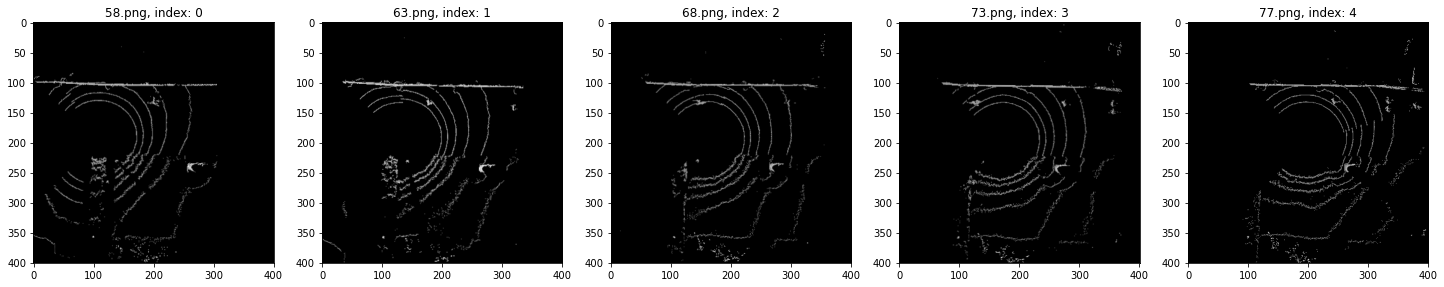

In [8]:
from lidar_helper import visualize_lidar_stack

# visualize mode returns lidar stack
# and the corresponding file names
lidar_stack = sample[0][0]
lidar_fnames = sample[0][1]

cprint(f'index: {idx}, total offset: 50', color='green', attrs=['bold'])
visualize_lidar_stack(lidar_stack=lidar_stack, file_names=lidar_fnames)

### Visualize Future Joystick in Table View

In [9]:
joystick = sample[1]
print('joystick dtype: ', joystick.dtype)
print('joystick shape: ', joystick.shape)

joy_df = pd.DataFrame(data=joystick, columns=['linear_x', 'linear_y', 'angular_z'])
joy_df

joystick dtype:  float32
joystick shape:  (300, 3)


,linear_x,linear_y,angular_z
0,1.6,0.0,-0.0
1,1.6,0.0,-0.0
2,1.6,0.0,-0.0
3,1.6,0.0,-0.0
4,1.6,0.0,-0.0
...,...,...,...
295,1.6,0.0,-0.0
296,1.6,0.0,-0.0
297,1.6,0.0,-0.0
298,1.6,0.0,-0.0


In [10]:
joystick = sample[1]
print('joystick shape: ', joystick.shape)

joy_df = pd.DataFrame(data=joystick, columns=['linear_x', 'linear_y', 'angular_z'])
joy_df

joystick shape:  (300, 3)


,linear_x,linear_y,angular_z
0,1.6,0.0,-0.0
1,1.6,0.0,-0.0
2,1.6,0.0,-0.0
3,1.6,0.0,-0.0
4,1.6,0.0,-0.0
...,...,...,...
295,1.6,0.0,-0.0
296,1.6,0.0,-0.0
297,1.6,0.0,-0.0
298,1.6,0.0,-0.0


### Display Some Joystick Stats

In [11]:
linear_x_max = joy_df['linear_x'].max()
linear_x_min = joy_df['linear_y'].min()
linear_x_avg = joy_df['linear_x'].mean()

linear_y_max = joy_df['linear_y'].max()
linear_y_min = joy_df['linear_y'].min()
linear_y_avg = joy_df['linear_y'].mean()

angular_z_max = joy_df['angular_z'].max()
angular_z_min = joy_df['angular_z'].min()
angular_z_avg = joy_df['angular_z'].mean()

In [12]:
joy_stats = {"linear_x": [linear_x_max, linear_x_min, linear_x_avg], "linear_y": [
    linear_y_max, linear_y_min, linear_y_avg], "angular_z": [angular_z_max, angular_z_min, angular_z_avg]}

joy_stats_df = pd.DataFrame(data=joy_stats, columns=[
                            'linear_x', 'linear_y', 'angular_z'], index=['max', 'min', 'avg'])

joy_stats_df


,linear_x,linear_y,angular_z
max,1.600000,0.000000,-0.0
min,-0.118818,-0.118818,-0.0
avg,1.600000,-0.003168,0.0


### Goal Information

In [13]:
goal = sample[2]
print(f'x: {goal[0]:.2f}, y: {goal[1]:.2f}')

x: 8.45, y: 4.95
